In [8]:

import pandas as pd
from sklearn import cluster, preprocessing
from sklearn.decomposition import PCA
import pylab as pl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tabulate import tabulate
import sklearn.metrics
from scipy.spatial.distance import cdist

#import hdbscan

"""
To check amount of NA values in any given column
-----
Usage
-----

count_na_in_col('URL')

"""
def cluster_elbow(df):
    clusters=range(1,10)
    meandist=[]

    for k in clusters:
        model=cluster.KMeans(n_clusters=k)
        model.fit(df)
        clusassign=model.predict(df)
        meandist.append(sum(np.min(cdist(df, model.cluster_centers_, 'euclidean'), axis=1)) 
        / df.shape[0])

    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of Squares')
    plt.title('Selecting k with the Elbow Method')
    plt.show()


def count_na_in_col(df, colname):
    return(sum(pd.isnull(df[colname])))


def preprocess(df):
    df_fill_na = df.fillna(df.mean())
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df_fill_na)
    df_normalized = pd.DataFrame(np_scaled, columns=df_fill_na.columns)
    return(df_normalized)

def get_elbow_plot(df):
    Nc = range(1, 20)
    kmeans = [cluster.KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
    pl.plot(Nc,score)
    pl.xlabel('Number of Clusters')
    pl.ylabel('Score')
    pl.title('Elbow Curve')
    pl.show()

def plot_pca_2d(df, clusterObj):
    pca = PCA(n_components=2).fit(df)
    pca_2d = pca.transform(df)
    pl.scatter(pca_2d[:, 0], pca_2d[:, 1],c=clusterObj.labels_)
    pl.xlabel("PCA_1")
    pl.ylabel("PCA_2")
    pl.show()
    pca_table = pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2'])
    print(tabulate(pca_table, headers='keys', tablefmt='psql'))

# 3 Dimensional PCA variables
"""
Change composition of bed_df
bed_df = survey_raw_df[['GENBD','PEDBD','OBBD','ACULTBD']]
bed_df = bed_df.fillna(bed_df.mean())

"""
def plot_3d_cluster(df, clusterObj):
    pca_3 = PCA(n_components=3).fit(df)
    pca_3d = pca_3.transform(df)
    angle_1 = plt.figure()
    ax = angle_1.add_subplot(111, projection='3d')
    ax.scatter(pca_3d[:, 0], pca_3d[:, 1],pca_3d[:,2], c=clusterObj.labels_, marker='o')
    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')
    ax.set_zlabel('PC-3')

    angle_2 = plt.figure()
    ax = angle_2.add_subplot(111, projection='3d')
    ax.scatter(pca_3d[:, 1], pca_3d[:, 2],pca_3d[:,0], c=clusterObj.labels_, marker='o')
    ax.set_xlabel('PC-2')
    ax.set_ylabel('PC-3')
    ax.set_zlabel('PC-1')

    angle_3 = plt.figure()
    ax = angle_3.add_subplot(111, projection='3d')
    ax.scatter(pca_3d[:, 2], pca_3d[:, 0],pca_3d[:,1], c=clusterObj.labels_, marker='o')
    ax.set_xlabel('PC-3')
    ax.set_ylabel('PC-1')
    ax.set_zlabel('PC-2')

    plt.show()
    pca_table = pd.DataFrame(pca_3.components_,columns=df.columns,index = ['PC-1','PC-2','PC-3'])
    print(tabulate(pca_table, headers='keys', tablefmt='psql'))


def get_survey_df( df, feature_list):
    df_filtered_features = df[feature_list]
    df_pre = preprocess( df_filtered_features)
    cluster_elbow(df_pre)
    return(df_pre)


def run_script(df, number_of_cluster):
    
    ########
    #KMEANS#
    ########
    print ('KMeans')
    kmeans= cluster.KMeans(n_clusters=number_of_cluster)
    kmeans.fit(df)
    plt.title("KMeans")
    plot_pca_2d(df, kmeans)
    #plot_3d_cluster(df, kmeans)

    ## AGGOLOMETRIVE
    print ('AgglomerativeClustering')
    agglometrativeObj = cluster.AgglomerativeClustering(linkage = 'ward',affinity='euclidean', n_clusters=number_of_cluster).fit(df)
    plt.title('AgglomerativeClustering')
    plot_pca_2d(df, agglometrativeObj)
    #plot_3d_cluster(df, agglometrativeObj)
    
    ## DBSCAN
    print ('DBSCAN')
    dbscanObj = cluster.DBSCAN(eps=0.1,min_samples=20).fit(df)
    plt.title('DBSCAN')
    plot_pca_2d(df, dbscanObj)
    #plot_3d_cluster(df,dbscanObj)

    ## SPECTRAL CLUSTERING
    print ('SpectralClustering')
    SpectralClustering = cluster.SpectralClustering(n_clusters=number_of_cluster).fit(df)
    plt.title('SpectralClustering')
    plot_pca_2d(df, SpectralClustering)
    #plot_3d_cluster(df,SpectralClustering)
    
    ## HDBSCAN
    #hdb = hdbscan.HDBSCAN(min_cluster_size = number_of_cluster)
    #plot_pca_2d(df, hdb)
    
    
    print ('silhouette_score comparing clustering algorithms')
    
    print("kmeans - " + str(sklearn.metrics.silhouette_score(df, kmeans.labels_, metric = 'euclidean')))
    print('agglomerative - ' + str(sklearn.metrics.silhouette_score(df, agglometrativeObj.labels_, metric = 'euclidean')))
    print('DBSCAN - ' + str(sklearn.metrics.silhouette_score(df, dbscanObj.labels_, metric = 'euclidean')))
    print('Spectral Clustering - ' + str(sklearn.metrics.silhouette_score(df, SpectralClustering.labels_, metric = 'euclidean')))
    #print(sklearn.metrics.silhouette_score(df, hdb.labels_, metric = 'euclidean'))


    
    return kmeans,agglometrativeObj, dbscanObj, SpectralClustering
   
    

def means_by_cluster(df, model):
    # Means by clusters    
    labels = model.labels_
    #st = 'clusters' +  
    df['clusters'] = labels
    clmns.extend(['clusters'])
    clus_mean = (df[clmns].groupby(['clusters']).mean()).T
    #clus_mean['avg'] = clus_mean.mean(axis = 1)
    x = df.clusters.value_counts()
    print(x)
    return clus_mean

In [3]:
df = pd.read_csv('C:/Users/Spurthi Bollina/Documents/AHA/Hospital Data with URLs.csv', encoding = "ISO-8859-1")


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,66,73,185,223) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# ASSETS

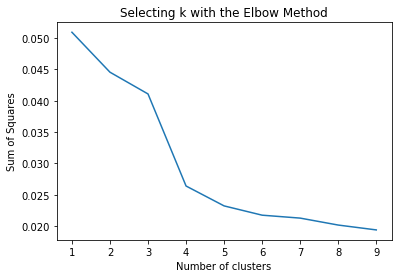

In [42]:
#PLNTA - Property, plant and equipment at cost
#ADEPRA - Accumulated depreciation
#ASSNET - Net property, plant and equipment
#GFEET - Total gross square feet of your physical plant
#CEAMT - Total Capital Expenditures
clmns = ['PLNTA','ADEPRA','ASSNET','GFEET','CEAMT']

df_assets = get_survey_df(df, feature_list = clmns)

KMeans


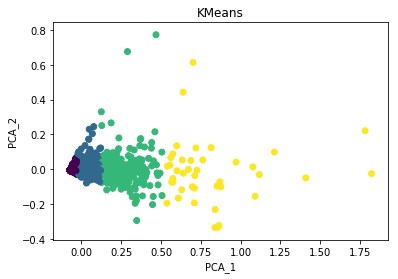

+------+-----------+-----------+-----------+----------+-----------+
|      |     PLNTA |    ADEPRA |    ASSNET |    GFEET |     CEAMT |
|------+-----------+-----------+-----------+----------+-----------|
| PC-1 |  0.520333 |  0.529218 |  0.490187 | 0.441623 |  0.11776  |
| PC-2 | -0.240265 | -0.102378 | -0.356394 | 0.864883 | -0.238227 |
+------+-----------+-----------+-----------+----------+-----------+
AgglomerativeClustering


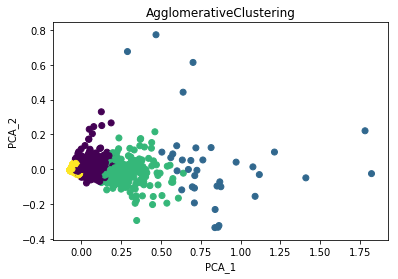

+------+-----------+-----------+-----------+----------+-----------+
|      |     PLNTA |    ADEPRA |    ASSNET |    GFEET |     CEAMT |
|------+-----------+-----------+-----------+----------+-----------|
| PC-1 |  0.520333 |  0.529218 |  0.490187 | 0.441623 |  0.11776  |
| PC-2 | -0.240265 | -0.102378 | -0.356394 | 0.864883 | -0.238227 |
+------+-----------+-----------+-----------+----------+-----------+
DBSCAN


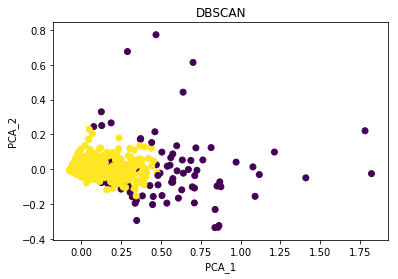

+------+-----------+-----------+-----------+----------+-----------+
|      |     PLNTA |    ADEPRA |    ASSNET |    GFEET |     CEAMT |
|------+-----------+-----------+-----------+----------+-----------|
| PC-1 |  0.520333 |  0.529218 |  0.490187 | 0.441623 |  0.11776  |
| PC-2 | -0.240265 | -0.102378 | -0.356394 | 0.864883 | -0.238227 |
+------+-----------+-----------+-----------+----------+-----------+
SpectralClustering


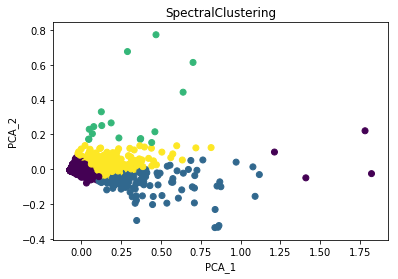

+------+-----------+-----------+-----------+----------+-----------+
|      |     PLNTA |    ADEPRA |    ASSNET |    GFEET |     CEAMT |
|------+-----------+-----------+-----------+----------+-----------|
| PC-1 |  0.520333 |  0.529218 |  0.490187 | 0.441623 |  0.11776  |
| PC-2 | -0.240265 | -0.102378 | -0.356394 | 0.864883 | -0.238227 |
+------+-----------+-----------+-----------+----------+-----------+
silhouette_score comparing clustering algorithms
kmeans - 0.593209834827
agglomerative - 0.539980660627
DBSCAN - 0.887256114133
Spectral Clustering - 0.703260071048


In [43]:
kmeans_assets,agg_assets, dbs_assets, sc_assets = run_script(df_assets,number_of_cluster = 4)

In [44]:
clus_mean_assets = means_by_cluster(df_assets, sc_assets)
clus_mean_assets

0    5668
3     435
1     131
2      17
Name: clusters, dtype: int64


clusters,0,1,2,3
PLNTA,0.024964,0.251398,0.098937,0.107491
ADEPRA,0.026455,0.239850,0.126221,0.123520
ASSNET,0.022543,0.251343,0.069764,0.088265
GFEET,0.026798,0.145112,0.440510,0.122198
CEAMT,0.005503,0.080150,0.012878,0.016759


# Bed Capacity

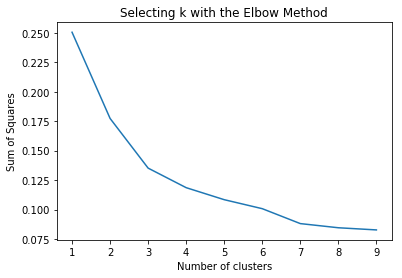

In [45]:
#BSC - Bed size code
#GENBD - General medical and surgical (adult) beds
#PEDBD - General medical and surgical (pediatric) beds
#OBBD - Obstetric care beds
#ACULTBD - Acute long-term care beds
#PSYBD - Psychiatric care beds
#ALCHBD - Alcohol/drug abuse or dependency inpatient care beds
#BRNBD - Burn care beds
#MSICBD - Medical/surgical intensive care beds
clmns = ['BSC','GENBD','PEDBD', 'OBBD', 'ACULTBD', 'PSYBD', 'ALCHBD', 'BRNBD', 'MSICBD']

df_cap = get_survey_df(df, feature_list = clmns)





KMeans


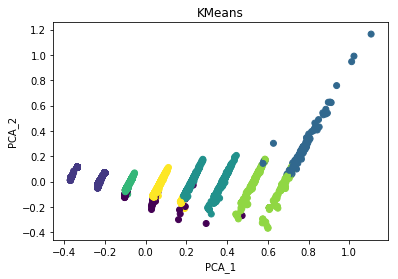

+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
|      |       BSC |    GENBD |     PEDBD |     OBBD |     ACULTBD |      PSYBD |     ALCHBD |    BRNBD |   MSICBD |
|------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------|
| PC-1 |  0.943634 | 0.206184 | 0.0684053 | 0.171857 | -0.00921875 |  0.0266608 |  0.0191807 | 0.038831 | 0.173659 |
| PC-2 | -0.319753 | 0.537578 | 0.0779618 | 0.529823 | -0.142928   | -0.0704686 | -0.0598348 | 0.143343 | 0.521974 |
+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
AgglomerativeClustering


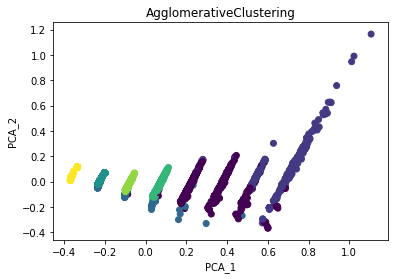

+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
|      |       BSC |    GENBD |     PEDBD |     OBBD |     ACULTBD |      PSYBD |     ALCHBD |    BRNBD |   MSICBD |
|------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------|
| PC-1 |  0.943634 | 0.206184 | 0.0684053 | 0.171857 | -0.00921875 |  0.0266608 |  0.0191807 | 0.038831 | 0.173659 |
| PC-2 | -0.319753 | 0.537578 | 0.0779618 | 0.529823 | -0.142928   | -0.0704686 | -0.0598348 | 0.143343 | 0.521974 |
+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
DBSCAN


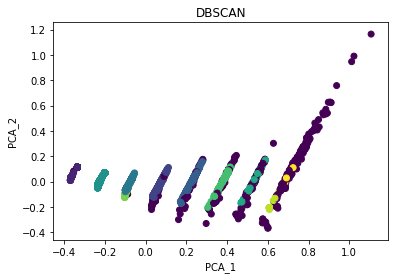

+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
|      |       BSC |    GENBD |     PEDBD |     OBBD |     ACULTBD |      PSYBD |     ALCHBD |    BRNBD |   MSICBD |
|------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------|
| PC-1 |  0.943634 | 0.206184 | 0.0684053 | 0.171857 | -0.00921875 |  0.0266608 |  0.0191807 | 0.038831 | 0.173659 |
| PC-2 | -0.319753 | 0.537578 | 0.0779618 | 0.529823 | -0.142928   | -0.0704686 | -0.0598348 | 0.143343 | 0.521974 |
+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
SpectralClustering


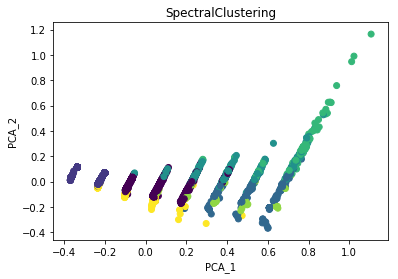

+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
|      |       BSC |    GENBD |     PEDBD |     OBBD |     ACULTBD |      PSYBD |     ALCHBD |    BRNBD |   MSICBD |
|------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------|
| PC-1 |  0.943634 | 0.206184 | 0.0684053 | 0.171857 | -0.00921875 |  0.0266608 |  0.0191807 | 0.038831 | 0.173659 |
| PC-2 | -0.319753 | 0.537578 | 0.0779618 | 0.529823 | -0.142928   | -0.0704686 | -0.0598348 | 0.143343 | 0.521974 |
+------+-----------+----------+-----------+----------+-------------+------------+------------+----------+----------+
silhouette_score comparing clustering algorithms
kmeans - 0.424794787919
agglomerative - 0.47298809288
DBSCAN - 0.463193410319
Spectral Clustering - 0.432645645999


In [46]:
kmeans_cap,agg_cap, dbs_cap, sc_cap = run_script(df_cap,number_of_cluster = 7)

In [47]:
### Agglomerative performs well on Bed Capacity data

clus_mean_cap = means_by_cluster(df_cap, agg_cap)
clus_mean_cap


3    1334
4    1234
5    1166
0    1085
6     770
1     461
2     201
Name: clusters, dtype: int64


clusters,0,1,2,3,4,5,6
BSC,0.636471,0.946390,0.233831,0.142857,0.428571,0.285714,0.000000
GENBD,0.102248,0.249494,0.002615,0.029623,0.057537,0.035723,0.027588
PEDBD,0.037214,0.069728,0.000728,0.006245,0.011586,0.008247,0.006184
OBBD,0.088033,0.193817,0.000642,0.021388,0.050992,0.030196,0.018344
ACULTBD,0.003724,0.002742,0.247253,0.003145,0.003864,0.003553,0.005756
PSYBD,0.021539,0.023269,0.000140,0.003947,0.012843,0.007942,0.004057
ALCHBD,0.018504,0.018194,0.000293,0.002876,0.007459,0.005583,0.002869
BRNBD,0.002858,0.062953,0.000000,0.001831,0.002526,0.001944,0.003213
MSICBD,0.080562,0.204467,0.009875,0.020607,0.049531,0.029020,0.017592


# Staff

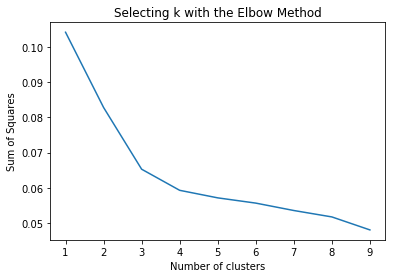

In [48]:

#FTMT      Total physicians engaged in arrangement with hospital
#FTMDTF    Full-time Physicians and dentists
#FTRES     Full-time medical and dental residents/interns
#FTTRAN    Full-time other trainees
#FTRNTF   Full-time registered nurses
#FTLPNTF Full-time licensed practical or vocational
#FTAST   Full-time nursing assistive personnel
#FTRAD    Full-time radiology technician
#FTLAB   Full-time laboratory technician
#FTPHR     Full-time pharmacists, licensed
#FTPHT     Full-time pharmacy technicians
#FTRESP   Full-time respiratory therapists
#FTOTHTF  Full-time all other personnel
#FTTOT    Full-time total personnel

clmns = [ 'FTMT','FTMDTF',
'FTRES',
'FTTRAN84',
'FTRNTF',
'FTLPNTF',
'FTAST',
'FTRAD',
'FTLAB',
'FTPHR',
'FTPHT',
'FTRESP',
'FTOTHTF',
'FTTOT']
df_staff = get_survey_df(df, feature_list = clmns)

KMeans


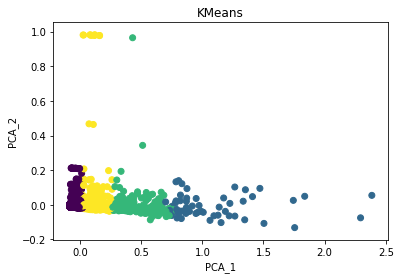

+------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------+
|      |      FTMT |     FTMDTF |       FTRES |   FTTRAN84 |     FTRNTF |    FTLPNTF |      FTAST |     FTRAD |       FTLAB |      FTPHR |     FTPHT |     FTRESP |     FTOTHTF |       FTTOT |
|------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------|
| PC-1 | 0.0436713 | 0.165069   | 0.266437    |  0.050621  | 0.36294    |  0.0696678 |  0.306453  | 0.335954  |  0.15478    |  0.393372  |  0.423615 | 0.133806   |  0.239089   |  0.347449   |
| PC-2 | 0.994261  | 0.00878736 | 0.000504268 | -0.0221529 | 0.00743816 | -0.0343612 | -0.0285867 | 0.0343814 | -0.00283668 | -0.0831636 | -0.022671 | 0.00694111 | -0.00883868 | -0.00874518 |
+------+-----------+------------+-------

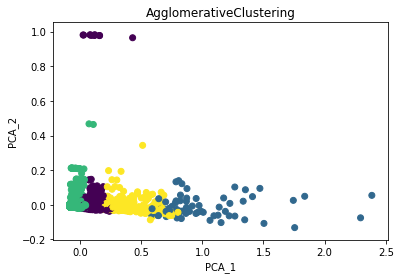

+------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------+
|      |      FTMT |     FTMDTF |       FTRES |   FTTRAN84 |     FTRNTF |    FTLPNTF |      FTAST |     FTRAD |       FTLAB |      FTPHR |     FTPHT |     FTRESP |     FTOTHTF |       FTTOT |
|------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------|
| PC-1 | 0.0436713 | 0.165069   | 0.266437    |  0.050621  | 0.36294    |  0.0696678 |  0.306453  | 0.335954  |  0.15478    |  0.393372  |  0.423615 | 0.133806   |  0.239089   |  0.347449   |
| PC-2 | 0.994261  | 0.00878742 | 0.000504236 | -0.0221529 | 0.00743854 | -0.0343612 | -0.0285867 | 0.0343813 | -0.00283628 | -0.0831636 | -0.022671 | 0.00694082 | -0.00883896 | -0.00874528 |
+------+-----------+------------+-------

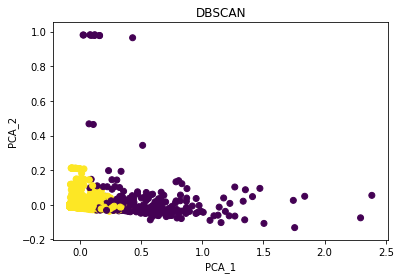

+------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------+
|      |      FTMT |     FTMDTF |       FTRES |   FTTRAN84 |     FTRNTF |    FTLPNTF |      FTAST |     FTRAD |       FTLAB |      FTPHR |     FTPHT |     FTRESP |     FTOTHTF |       FTTOT |
|------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+-----------+------------+-------------+-------------|
| PC-1 | 0.0436713 | 0.165069   | 0.266437    |  0.050621  | 0.36294    |  0.0696678 |  0.306453  | 0.335954  |  0.15478    |  0.393372  |  0.423615 | 0.133806   |  0.239089   |  0.347449   |
| PC-2 | 0.994261  | 0.00878747 | 0.000504262 | -0.0221529 | 0.00743843 | -0.0343612 | -0.0285867 | 0.0343812 | -0.00283614 | -0.0831635 | -0.022671 | 0.00694112 | -0.00883906 | -0.00874535 |
+------+-----------+------------+-------

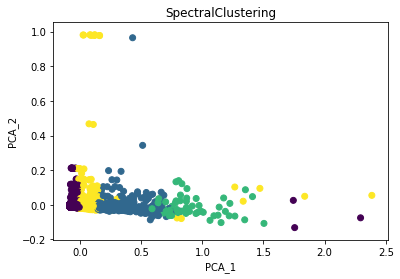

+------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+------------+------------+-------------+-------------+
|      |      FTMT |     FTMDTF |       FTRES |   FTTRAN84 |     FTRNTF |    FTLPNTF |      FTAST |     FTRAD |       FTLAB |      FTPHR |      FTPHT |     FTRESP |     FTOTHTF |       FTTOT |
|------+-----------+------------+-------------+------------+------------+------------+------------+-----------+-------------+------------+------------+------------+-------------+-------------|
| PC-1 | 0.0436713 | 0.165069   | 0.266437    |  0.050621  | 0.36294    |  0.0696678 |  0.306453  | 0.335954  |  0.15478    |  0.393372  |  0.423615  | 0.133806   |  0.239089   |  0.347449   |
| PC-2 | 0.994261  | 0.00878775 | 0.000504105 | -0.0221529 | 0.00744026 | -0.0343611 | -0.0285868 | 0.0343807 | -0.00283527 | -0.0831638 | -0.0226708 | 0.00693951 | -0.00884007 | -0.00874561 |
+------+-----------+------------+--

In [49]:
kmeans_staff,agg_staff, dbs_staff, sc_staff = run_script(df_staff,number_of_cluster = 4)

In [50]:
### KMeans performs well on staff clusters

clus_mean_staff = means_by_cluster(df_staff, kmeans_staff)
clus_mean_staff

0    4852
3    1125
2     217
1      57
Name: clusters, dtype: int64


clusters,0,1,2,3
FTMT,0.012197,0.052162,0.033085,0.025377
FTMDTF,0.002676,0.196150,0.079416,0.019794
FTRES,0.000789,0.419880,0.105874,0.013845
FTTRAN84,0.000399,0.076275,0.016390,0.003733
FTRNTF,0.011929,0.392590,0.194906,0.075318
FTLPNTF,0.004485,0.073640,0.045243,0.015627
FTAST,0.015362,0.331823,0.175944,0.070688
FTRAD,0.013511,0.368642,0.176685,0.067422
FTLAB,0.004619,0.186668,0.069757,0.024000
FTPHR,0.010110,0.438892,0.205791,0.074894


# Combined Feature Set

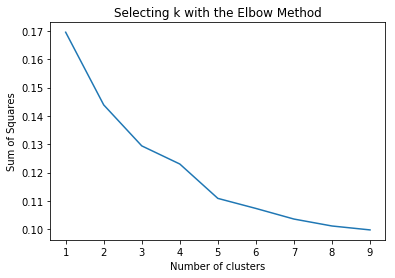

In [33]:

clmns = ['PLNTA','ADEPRA','ASSNET','GFEET','CEAMT', 'GENBD', 'PEDBD', 'OBBD', 'ACULTBD', 'PSYBD', 'ALCHBD', 'BRNBD', 'MSICBD', 'FTMT','FTMDTF',
'FTRES',
'FTTRAN84',
'FTRNTF',
'FTLPNTF',
'FTAST',
'FTRAD',
'FTLAB',
'FTPHR',
'FTPHT',
'FTRESP',
'FTOTHTF',
'FTTOT']
df_all = get_survey_df(df, feature_list = clmns)



KMeans


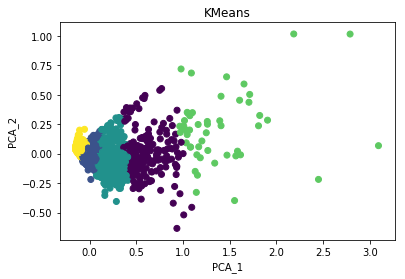

+------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------+
|      |     PLNTA |    ADEPRA |    ASSNET |     GFEET |     CEAMT |     GENBD |    PEDBD |      OBBD |    ACULTBD |     PSYBD |    ALCHBD |     BRNBD |    MSICBD |       FTMT |   FTMDTF |    FTRES |   FTTRAN84 |    FTRNTF |   FTLPNTF |     FTAST |     FTRAD |     FTLAB |    FTPHR |    FTPHT |    FTRESP |   FTOTHTF |    FTTOT |
|------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------|
| PC-1 | 0

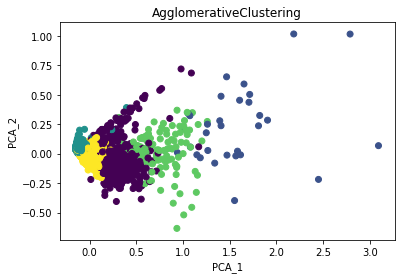

+------+-----------+-----------+----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------+
|      |     PLNTA |    ADEPRA |   ASSNET |     GFEET |     CEAMT |     GENBD |    PEDBD |      OBBD |    ACULTBD |     PSYBD |    ALCHBD |     BRNBD |    MSICBD |       FTMT |   FTMDTF |    FTRES |   FTTRAN84 |    FTRNTF |   FTLPNTF |     FTAST |     FTRAD |     FTLAB |    FTPHR |    FTPHT |      FTRESP |   FTOTHTF |    FTTOT |
|------+-----------+-----------+----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------|
| PC-1 

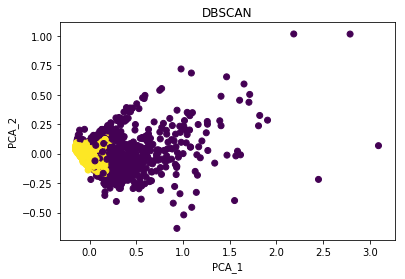

+------+-----------+-----------+-----------+----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------+
|      |     PLNTA |    ADEPRA |    ASSNET |    GFEET |     CEAMT |     GENBD |    PEDBD |      OBBD |    ACULTBD |     PSYBD |    ALCHBD |     BRNBD |    MSICBD |       FTMT |   FTMDTF |    FTRES |   FTTRAN84 |    FTRNTF |   FTLPNTF |     FTAST |     FTRAD |     FTLAB |    FTPHR |    FTPHT |      FTRESP |   FTOTHTF |    FTTOT |
|------+-----------+-----------+-----------+----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------|
| PC-1 

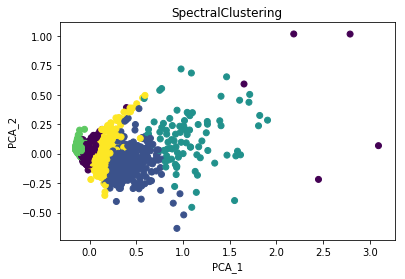

+------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------+
|      |     PLNTA |    ADEPRA |    ASSNET |     GFEET |     CEAMT |     GENBD |    PEDBD |      OBBD |    ACULTBD |     PSYBD |    ALCHBD |     BRNBD |    MSICBD |       FTMT |   FTMDTF |    FTRES |   FTTRAN84 |    FTRNTF |   FTLPNTF |     FTAST |     FTRAD |     FTLAB |    FTPHR |    FTPHT |      FTRESP |   FTOTHTF |    FTTOT |
|------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+------------+-----------+-----------+-----------+-----------+------------+----------+----------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-------------+-----------+----------|
| PC

In [34]:
kmeans_all,agg_all, dbs_all, sc_all = run_script(df_all,number_of_cluster = 5)

In [35]:
### Agglomerative performs well on staff clusters

clus_mean_all = means_by_cluster(df_all, kmeans_all)
clus_mean_all

1    2648
4    2598
2     769
0     186
3      50
Name: clusters, dtype: int64


clusters,0,1,2,3,4
PLNTA,0.161492,0.033181,0.071935,0.400241,0.011409
ADEPRA,0.177355,0.035177,0.078349,0.391004,0.012052
ASSNET,0.140133,0.029951,0.063019,0.391772,0.010338
GFEET,0.142032,0.035995,0.071615,0.352405,0.014288
CEAMT,0.039484,0.007134,0.012919,0.100403,0.003082
GENBD,0.259855,0.067032,0.152343,0.419747,0.013828
PEDBD,0.108056,0.016657,0.040087,0.192744,0.001926
OBBD,0.208820,0.057236,0.136354,0.250599,0.006927
ACULTBD,0.005633,0.006809,0.003220,0.000000,0.019625
PSYBD,0.022839,0.010152,0.013874,0.037826,0.009212


## Merging Orginal data with Clusters

In [41]:
# Aggregated Cluster

df_all.reset_index(level = 0, inplace=True)
df['index'] = df.index
df_new = pd.merge(df, df_all[['clusters', 'index']], on = 'index')


df_new = df_new.rename(columns={'clusters': 'Aggregated Cluster'})
#df_new.head()


,ID,URL,STCD,DTBEG,DTEND,DCOV,FYR,FISYR,CNTRL,SERV,...,INDIA,OFRNRS,RNSCH,PLNTA,ADEPRA,ASSNET,GFEET,CEAMT,index,Aggregated Cluster
0,6030010,NaN,3,NaN,NaN,0,NaN,NaN,42,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,6040001,NaN,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,6040002,www.metropavia.com/SanFrancisco.cfm,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
3,6040004,himasanpablo.com,4,10115.0,123115.0,365,1.0,10116.0,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
4,6040005,www.hbspr.org,4,NaN,NaN,0,NaN,NaN,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1


In [52]:
# Asset
df_assets['index'] = df_assets.index
df_new = pd.merge(df_new, df_assets[['clusters', 'index']], on = 'index')
df_new = df_new.rename(columns={'clusters': 'Assets'})
#df_new.head()

,ID,URL,STCD,DTBEG,DTEND,DCOV,FYR,FISYR,CNTRL,SERV,...,OFRNRS,RNSCH,PLNTA,ADEPRA,ASSNET,GFEET,CEAMT,index,Aggregated Cluster,Asset
0,6030010,NaN,3,NaN,NaN,0,NaN,NaN,42,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
1,6040001,NaN,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
2,6040002,www.metropavia.com/SanFrancisco.cfm,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0
3,6040004,himasanpablo.com,4,10115.0,123115.0,365,1.0,10116.0,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,0
4,6040005,www.hbspr.org,4,NaN,NaN,0,NaN,NaN,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,0


In [53]:
# Bed Capacity
df_cap['index'] = df_cap.index
df_new = pd.merge(df_new, df_cap[['clusters', 'index']], on = 'index')
df_new = df_new.rename(columns={'clusters': 'Bed Capacity'})
#df_new.head()

,ID,URL,STCD,DTBEG,DTEND,DCOV,FYR,FISYR,CNTRL,SERV,...,RNSCH,PLNTA,ADEPRA,ASSNET,GFEET,CEAMT,index,Aggregated Cluster,Asset,Bed Capacity
0,6030010,NaN,3,NaN,NaN,0,NaN,NaN,42,10,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,6
1,6040001,NaN,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,4
2,6040002,www.metropavia.com/SanFrancisco.cfm,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,4
3,6040004,himasanpablo.com,4,10115.0,123115.0,365,1.0,10116.0,33,10,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,0,1
4,6040005,www.hbspr.org,4,NaN,NaN,0,NaN,NaN,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,4,1,0,4


In [54]:
# staff
df_staff['index'] = df_staff.index
df_new = pd.merge(df_new, df_staff[['clusters', 'index']], on = 'index')
df_new = df_new.rename(columns={'clusters': 'Staff'})
#df_new.head()

,ID,URL,STCD,DTBEG,DTEND,DCOV,FYR,FISYR,CNTRL,SERV,...,PLNTA,ADEPRA,ASSNET,GFEET,CEAMT,index,Aggregated Cluster,Asset,Bed Capacity,Staff
0,6030010,NaN,3,NaN,NaN,0,NaN,NaN,42,10,...,NaN,NaN,NaN,NaN,NaN,0,1,0,6,0
1,6040001,NaN,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,1,1,0,4,0
2,6040002,www.metropavia.com/SanFrancisco.cfm,4,NaN,NaN,0,NaN,NaN,33,10,...,NaN,NaN,NaN,NaN,NaN,2,1,0,4,0
3,6040004,himasanpablo.com,4,10115.0,123115.0,365,1.0,10116.0,33,10,...,NaN,NaN,NaN,NaN,NaN,3,2,0,1,3
4,6040005,www.hbspr.org,4,NaN,NaN,0,NaN,NaN,23,10,...,NaN,NaN,NaN,NaN,NaN,4,1,0,4,0


In [58]:
df_subset = df_new[['ID', 'CBSATYPE', 'MNAME', 'MLOCADDR', 'MLOCCITY', 'MLOCSTCD', 'MLOCZIP', 'Aggregated Cluster', 'Asset', 'Bed Capacity', 'Staff']]
df_subset.to_csv('Clustering on Hospitals.csv', sep=',', encoding='utf-8')